## Step 1: Remove Useless columns
In this step, we load all Shopify order files and combine them into a single DataFrame. We then remove columns that are either not useful for modeling (e.g., customer addresses or always-null fields) or columns that are filled in less than 5% of the rows. This results in a cleaner dataset with fewer missing values and less noise, which is essential for downstream modeling tasks.

In [1]:
import pandas as pd
import os

RAW_DATA_PATH = os.path.join("..", "resources", "data", "raw", "clv")
PROCESSED_DATA_PATH = os.path.join("..", "resources", "data", "processed", "clv")
output_path = os.path.join(PROCESSED_DATA_PATH, "orders_cleaned_columns.csv")

# File paths
order_files = [
    os.path.join(RAW_DATA_PATH, "orders_export_2.csv"),
    os.path.join(RAW_DATA_PATH, "orders_export_3.csv"),
    os.path.join(RAW_DATA_PATH, "orders_export_1.csv"),
]

##########step 1 all orders in one dataframe##########
# all orders tables in one dataframe
orders_df = pd.concat([pd.read_csv(file) for file in order_files], ignore_index=True)


################step 2 remove useless columns###############
not_useful_columns = [
    "Billing Name",
    'Billing Street', 
    'Billing Address1', 
    'Billing Address2',
    "Currency", # always EUR
    "Shipping", # always 0
    "Shipping Method", # always "PostNL or nothing"
    "Lineitem name", # we already have an item sku
    "Lineitem compare at price", # always empty
    "Lineitem requires shipping", # always TRUE
    "Lineitem taxable", # always TRUE
    "Lineitem fulfillment status", # we have a column that indicates if the order is fulfilled or not 
    "Billing Phone", # (customer phone number) private customer information & does not benifit the model
    "Shipping Name", # ( customer name ) private customer information & does not benifit the model
    "Shipping Street", # ( customer address ) private customer information & does not benifit the model
    "Shipping Address1", # ( customer address ) private customer information & does not benifit the model
    "Shipping Address2", # ( customer address ) private customer information & does not benifit the model
    "Shipping Company", # ( customer address ) private customer information & does not benifit the model
    "Shipping Zip", # ( customer address ) private customer information & does not benifit the model
    "Shipping Phone", # ( customer phone number ) private customer information & does not benifit the model
    "Notes", # Payment notes are not useful for the model
    "Note Attributes", # Payment notes are not useful for the model
    "Payment Reference", # Payment notes are not useful for the model
    "Vendor", # always Moodies Undies
    "Outstanding Balance", # Does not benifit the model
    "Tax 1 Name", # Does not benifit the model
    "Tax 1 Value", # Does not benifit the model
    "Tax 2 Name", # Does not benifit the model
    "Tax 2 Value", # Does not benifit the model
    "Tax 3 Name", # Does not benifit the model
    "Tax 3 Value", # Does not benifit the model
    "Tax 4 Name", # Does not benifit the model
    "Tax 4 Value", # Does not benifit the model
    "Tax 5 Name", # Does not benifit the model
    "Tax 5 Value", # Does not benifit the model
    "Phone", # ( customer phone number ) private customer information & does not benifit the model
    "Receipt Number", # Does not benifit the model
    "Payment Terms Name",
    "Next Payment Due At",
    "Payment References"
]

orders_df.drop(columns=not_useful_columns, inplace=True, errors="ignore")




orders_df.to_csv(output_path, index=False)
orders_df.head()

C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\3489607944.py:17: DtypeWarning: Columns (27,28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_df = pd.concat([pd.read_csv(file) for file in order_files], ignore_index=True)
C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\3489607944.py:17: DtypeWarning: Columns (44,52) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_df = pd.concat([pd.read_csv(file) for file in order_files], ignore_index=True)


,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Subtotal,Taxes,Total,...,Device ID,Id,Tags,Risk Level,Source,Lineitem discount,Duties,Billing Province Name,Shipping Province Name,Payment ID
0,31607,tinekesnelting@outlook.com,paid,2024-02-26 15:41:51 +0100,fulfilled,2024-02-26 15:41:55 +0100,yes,90.11,8.22,90.11,...,NaN,5.213434e+12,NaN,Low,Matrixify App,0.0,NaN,NaN,NaN,31607.1
1,31607,tinekesnelting@outlook.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,31607,tinekesnelting@outlook.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,31607,tinekesnelting@outlook.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,31602,marianvanweert@gmail.com,paid,2024-02-26 15:41:51 +0100,fulfilled,2024-02-26 15:41:54 +0100,no,124.39,11.82,124.39,...,NaN,5.213434e+12,NaN,Low,Matrixify App,0.0,NaN,NaN,NaN,31602.1


## Step 2: Combine Multiple Rows Into One Per Order
Shopify splits a single order into multiple rows if it contains multiple unique items. This step identifies such rows using the 'Email' and 'Name' (which is the id of an order) fields, and merges them by combining their line items into a single list. Additionally, duplicate orders are filtered to keep only the fulfilled ones. The result is a dataset where each order occupies one row.

In [2]:
orders_file = os.path.join(PROCESSED_DATA_PATH, "orders_cleaned_columns.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "orders_have_one_row.csv")
orders_df = pd.read_csv(orders_file)

orders_df["Lineitems"] = orders_df.apply(
    lambda row: [{row["Lineitem sku"] if pd.notna(row["Lineitem sku"]) else "unknown": row["Lineitem quantity"]}],
    axis=1
)

rows_to_drop = []
for i in range(1, len(orders_df)):
    current_row = orders_df.loc[i]
    previous_row = orders_df.loc[i - 1]
    if pd.isna(current_row["Paid at"]) and current_row["Name"] == previous_row["Name"] and current_row["Email"] == previous_row["Email"]:
        prev_items = previous_row["Lineitems"]
        curr_items = current_row["Lineitems"]
        prev_items.extend(curr_items)
        orders_df.at[i - 1, "Lineitems"] = prev_items
        rows_to_drop.append(i)

orders_df.drop(index=rows_to_drop, inplace=True)
orders_df.reset_index(drop=True, inplace=True)

# Remove duplicated orders unless fulfilled
duplicate_names = orders_df["Name"][orders_df["Name"].duplicated(keep=False)]
filtered_orders_df = orders_df[
    ~orders_df["Name"].isin(duplicate_names) |
    (orders_df["Fulfillment Status"] == "fulfilled")
]
filtered_orders_df = filtered_orders_df.drop_duplicates(subset="Name", keep="first")
orders_df = filtered_orders_df.reset_index(drop=True)

orders_df.to_csv(output_path, index=False)
print(f"Updated file saved to: {output_path}")
orders_df.head()


C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\2781036063.py:3: DtypeWarning: Columns (0,19,22,27,31,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_df = pd.read_csv(orders_file)


Updated file saved to: ..\resources\data\processed\clv\orders_have_one_row.csv


,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Subtotal,Taxes,Total,...,Id,Tags,Risk Level,Source,Lineitem discount,Duties,Billing Province Name,Shipping Province Name,Payment ID,Lineitems
0,31607,tinekesnelting@outlook.com,paid,2024-02-26 15:41:51 +0100,fulfilled,2024-02-26 15:41:55 +0100,yes,90.11,8.22,90.11,...,5.213434e+12,NaN,Low,Matrixify App,0.0,NaN,NaN,NaN,31607.1,"[{'MH-003-NXXL': 1}, {'MS-006-GXXL': 1}]"
1,31602,marianvanweert@gmail.com,paid,2024-02-26 15:41:51 +0100,fulfilled,2024-02-26 15:41:54 +0100,no,124.39,11.82,124.39,...,5.213434e+12,NaN,Low,Matrixify App,0.0,NaN,NaN,NaN,31602.1,"[{'YH-005-ZS': 2}, {'YM-005-ZS': 3}]"
2,31612,jannekefaro@msn.com,paid,2024-02-26 15:41:51 +0100,fulfilled,2024-02-26 15:41:56 +0100,no,24.25,2.00,24.25,...,5.213434e+12,NaN,Low,Matrixify App,0.0,NaN,NaN,NaN,31612.1,[{'YM-006-ZXS': 1}]
3,31608,kruijer.ahc@gmail.com,paid,2024-02-26 15:41:50 +0100,fulfilled,2024-02-26 15:41:54 +0100,no,33.95,2.80,33.95,...,5.213434e+12,NaN,Low,Matrixify App,0.0,NaN,NaN,NaN,31608.1,[{'SY-001-Z-S': 1}]
4,31598,thereselaoshan@hotmail.com,refunded,2024-02-26 15:41:50 +0100,unfulfilled,NaN,no,33.90,2.80,33.90,...,5.213434e+12,NaN,Low,Matrixify App,0.0,NaN,NaN,NaN,31598.1,"[{'YM-006-GXXS': 1}, {'YW-001': 1}]"


## Step 3: Merge Klaviyo Customer Data
We merge the cleaned Shopify order data with customer profile data from Klaviyo using the 'Email' field. This ensures that we capture both customers who have made purchases and those who have not. The result is a dataset that combines behavioral (order-based) and demographic (profile-based) information.

In [3]:
orders_file = os.path.join(PROCESSED_DATA_PATH, "orders_have_one_row.csv")
klaviyo_file = os.path.join(RAW_DATA_PATH, "Klaviyo_everyone_email.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "orders_with_customer_data.csv")

orders_df = pd.read_csv(orders_file)
customers_df = pd.read_csv(klaviyo_file)

merged_df = pd.merge(
    customers_df,
    orders_df,
    on="Email",
    how="outer",
    suffixes=("", "_order")
)

merged_df.to_csv(output_path, index=False)
print(f"Merged file with all customers saved to: {output_path}")
merged_df.head()


C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\3544684866.py:5: DtypeWarning: Columns (19,22,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_df = pd.read_csv(orders_file)
C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\3544684866.py:6: DtypeWarning: Columns (6,65,66,68,72) have mixed types. Specify dtype option on import or set low_memory=False.
  customers_df = pd.read_csv(klaviyo_file)


Merged file with all customers saved to: ..\resources\data\processed\clv\orders_with_customer_data.csv


,Email,First Name,Last Name,Organization,Locale,Title,Phone Number,Address,Address 2,City,...,Id,Tags,Risk Level,Source,Lineitem discount,Duties,Billing Province Name,Shipping Province Name,Payment ID,Lineitems
0,'wolters.bente@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.499659e+12,Klarna,Low,web,0.0,NaN,NaN,NaN,rKvQx5zKUzr2nfSlEXeD6fwoU,"[{'YM-006-D1XS': 1}, {'MH-006-BL': 1}]"
1,01.chocolade-macumba@icloud.com,Marianne,Verspeek,NaN,nl-NL,NaN,NaN,Handboogstraat 6,NaN,Valkenswaard,...,5.241586e+12,NaN,Low,web,0.0,NaN,NaN,NaN,r2bYEn6OoqnPsrykI8f3xP9fJ,[{'MM-006-ZM': 3}]
2,01docile_ream@icloud.com,Metta,Pratt,NaN,NaN,NaN,NaN,Van Musschenbroekstraat 50,NaN,Utrecht,...,5.367475e+12,NaN,Low,web,0.0,NaN,NaN,NaN,rv34UvWPYX2jKBSybtYHfWI6P,[{'MM-001-NS': 1}]
3,01wendy@planet.nl,Jade,Kalkman,NaN,nl-NL,NaN,NaN,Dominicanenlaan 16,NaN,Alphen aan den Rijn,...,5.500696e+12,NaN,Low,web,0.0,NaN,NaN,NaN,rCAQSkvy8S5w5SPzrmCF14VMx,"[{'YH-006-ZXS': 1}, {'SY-004-ZXS': 1}]"
4,0303.nicole@gmail.com,Nicole,Kanters,NaN,NaN,NaN,+31651658796,De Mortelkes 11,NaN,Erp,...,5.200949e+12,NaN,Low,Matrixify App,0.0,NaN,NaN,NaN,13225.1,[{'ML-004-ZL': 1}]


## Step 4: Remove columns that are filled for in less than 5 percent of the rows

In [4]:

input_path = os.path.join(PROCESSED_DATA_PATH, "orders_with_customer_data.csv")
output_path = os.path.join(PROCESSED_DATA_PATH, "orders_with_customer_data_no_empty_columns.csv")

def get_fill_percentages(df: pd.DataFrame) -> dict:
    """
    Returns a dictionary with the percentage of filled (non-null and non-empty) rows per column.

    :param df: DataFrame to inspect.
    :return: Dictionary {column_name: fill_percentage}
    """
    total_rows = len(df)
    fill_percentages = {}

    for col in df.columns:
        non_empty = df[col].notna() & (df[col].astype(str).str.strip() != "")
        fill_percentage = (non_empty.sum() / total_rows) * 100
        fill_percentages[col] = round(fill_percentage, 2)

    return fill_percentages


orders_with_customer_df = pd.read_csv(input_path)
fill_stats = get_fill_percentages(orders_with_customer_df)

for col, pct in fill_stats.items():
    print(f"{col}: {pct}% filled")
    if pct < 5:
        print(f"{col} has a fill rate of {pct}% which is below the threshold of 95%. column {col} will be dropped.")
        orders_df.drop(columns=[col], inplace=True, errors="ignore")

C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\1328339009.py:22: DtypeWarning: Columns (6,65,66,68,72,95,100,110) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_with_customer_df = pd.read_csv(input_path)


Email: 99.95% filled
First Name: 74.49% filled
Last Name: 62.29% filled
Organization: 1.7% filled
Organization has a fill rate of 1.7% which is below the threshold of 95%. column Organization will be dropped.
Locale: 46.61% filled
Title: 0.0% filled
Title has a fill rate of 0.0% which is below the threshold of 95%. column Title will be dropped.
Phone Number: 51.66% filled
Address: 54.77% filled
Address 2: 5.38% filled
City: 79.23% filled
Country: 81.57% filled
Email Marketing Consent: 98.13% filled
Email Marketing Consent Timestamp: 78.21% filled
SMS Marketing Consent: 0.0% filled
SMS Marketing Consent has a fill rate of 0.0% which is below the threshold of 95%. column SMS Marketing Consent will be dropped.
SMS Marketing Consent Timestamp: 0.0% filled
SMS Marketing Consent Timestamp has a fill rate of 0.0% which is below the threshold of 95%. column SMS Marketing Consent Timestamp will be dropped.
SMS Transactional Consent: 0.0% filled
SMS Transactional Consent has a fill rate of 0.0% 

## Step 5: Create Monthly Spend and Order Features
Here, we engineer new features for modeling. For each customer, we compute the number of orders and the amount spent in each month. These features are crucial for understanding customer behavior over time and are especially useful for predicting future value.

In [5]:
orders_file = os.path.join(PROCESSED_DATA_PATH, "orders_have_one_row.csv")
output_file = os.path.join(PROCESSED_DATA_PATH, "monthly_customer_stats.csv")

orders_df = pd.read_csv(orders_file, low_memory=False)
orders_df["Paid at"] = pd.to_datetime(orders_df["Paid at"], utc=True, errors="coerce")
orders_df = orders_df.dropna(subset=["Paid at"])
orders_df["YearMonth"] = orders_df["Paid at"].dt.strftime("%Y_%m")

monthly_summary = orders_df.groupby(["Email", "YearMonth"]).agg(
    orders_per_month=("Name", "count"),
    amount_per_month=("Total", "sum")
).reset_index()

order_counts = monthly_summary.pivot(index="Email", columns="YearMonth", values="orders_per_month")
amounts_spent = monthly_summary.pivot(index="Email", columns="YearMonth", values="amount_per_month")

order_counts = order_counts.reindex(sorted(order_counts.columns), axis=1)
amounts_spent = amounts_spent.reindex(sorted(amounts_spent.columns), axis=1)

order_counts.columns = [f"orders_in_{col}" for col in order_counts.columns]
amounts_spent.columns = [f"amount_spent_{col}" for col in amounts_spent.columns]

monthly_stats = pd.concat([order_counts, amounts_spent], axis=1)
monthly_stats["total_amount_spent"] = orders_df.groupby("Email")["Total"].sum()

monthly_stats = monthly_stats.reset_index()
monthly_stats.to_csv(output_file, index=False)
print(f"Monthly customer stats saved to: {output_file}")
monthly_stats.head()


Monthly customer stats saved to: ..\resources\data\processed\clv\monthly_customer_stats.csv


,Email,orders_in_2024_02,orders_in_2024_03,orders_in_2024_04,orders_in_2024_05,orders_in_2024_06,orders_in_2024_07,orders_in_2024_08,orders_in_2024_09,orders_in_2024_10,...,amount_spent_2024_07,amount_spent_2024_08,amount_spent_2024_09,amount_spent_2024_10,amount_spent_2024_11,amount_spent_2024_12,amount_spent_2025_01,amount_spent_2025_02,amount_spent_2025_03,total_amount_spent
0,'wolters.bente@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,42.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.58
1,01.chocolade-macumba@icloud.com,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.96
2,01docile_ream@icloud.com,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.95
3,01wendy@planet.nl,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,128.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.66
4,0303.nicole@gmail.com,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.76


## Step 5: Merge Monthly Features Into Full Dataset
In this final preprocessing step, we merge the engineered monthly features into the combined Klaviyo + Shopify dataset. This gives us one complete table that includes customer profile data, order history, and time-based behavioral features, ready for training a Customer Lifetime Value prediction model.

In [6]:
orders_customers_file = os.path.join(PROCESSED_DATA_PATH, "orders_with_customer_data.csv")
monthly_stats_file = os.path.join(PROCESSED_DATA_PATH, "monthly_customer_stats.csv")
output_file = os.path.join(PROCESSED_DATA_PATH, "final_merged_data.csv")

orders_customers_df = pd.read_csv(orders_customers_file)
monthly_stats_df = pd.read_csv(monthly_stats_file)

final_df = pd.merge(
    orders_customers_df,
    monthly_stats_df,
    on="Email",
    how="left"
)

final_df.to_csv(output_file, index=False)
print(f"Final merged dataset saved to: {output_file}")
final_df.head()


C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\1635929017.py:5: DtypeWarning: Columns (6,65,66,68,72,95,100,110) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_customers_df = pd.read_csv(orders_customers_file)


Final merged dataset saved to: ..\resources\data\processed\clv\final_merged_data.csv


,Email,First Name,Last Name,Organization,Locale,Title,Phone Number,Address,Address 2,City,...,amount_spent_2024_07,amount_spent_2024_08,amount_spent_2024_09,amount_spent_2024_10,amount_spent_2024_11,amount_spent_2024_12,amount_spent_2025_01,amount_spent_2025_02,amount_spent_2025_03,total_amount_spent
0,'wolters.bente@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,42.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.58
1,01.chocolade-macumba@icloud.com,Marianne,Verspeek,NaN,nl-NL,NaN,NaN,Handboogstraat 6,NaN,Valkenswaard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.96
2,01docile_ream@icloud.com,Metta,Pratt,NaN,NaN,NaN,NaN,Van Musschenbroekstraat 50,NaN,Utrecht,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.95
3,01wendy@planet.nl,Jade,Kalkman,NaN,nl-NL,NaN,NaN,Dominicanenlaan 16,NaN,Alphen aan den Rijn,...,NaN,128.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,128.66
4,0303.nicole@gmail.com,Nicole,Kanters,NaN,NaN,NaN,31651658796.0,De Mortelkes 11,NaN,Erp,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.76


### Step 6 – Final Feature Selection and Aggregation

In this step, we finalized our customer-level dataset by cleaning, transforming, and aggregating features to prepare them for modeling.

#### Column Filtering
We removed over 70 columns that were either:
- Sensitive (e.g. names, addresses, phone numbers)
- Duplicated or irrelevant for modeling
- High-cardinality categorical columns unlikely to provide predictive power
- System-generated metadata or unused campaign tracking codes

#### Boolean Normalization
We identified object-type columns that semantically represented booleans (e.g., `InWelcomeFlow`, `InCheckoutAbandonmentFlow`, `Accepts Marketing`) and explicitly converted them to `True`/`False`, filling missing values as `False`.

#### Location Cleanup
Missing values in the `Country` column were assumed to be “Netherlands”, as that is the primary market. Missing `City`, `Last Source`, and `Campaign` fields were filled with `"unknown"` or `"(direct)"` where applicable.

#### Date Feature Engineering
We engineered customer timeline features based on:
- First and last activity
- First and last purchase
- Days since email marketing consent

This resulted in numerical columns like `days_since_first_active` and `customer_lifetime_days`, giving the model a richer temporal understanding of each customer.

#### Email Marketing Consent
Instead of treating `Email Marketing Consent Timestamp` as a raw date, we extracted:
- `email_marketing_optin`: binary indicator if consent was ever given
- `days_since_email_optin`: numeric time since consent (or -1 if not given)

This allowed us to convert a sparse timestamp into usable model features.

#### Lineitem Breakdown
Each row in the dataset originally represented a customer order and contained a `Lineitems` field — a list of `{sku: quantity}` dictionaries.
We:
- Counted total quantities (`total_amount_line_items_bought`)
- Extracted the first and second unique SKUs bought, plus their quantities (`first_item_sku`, `first_item_qty`, etc.)

This allowed us to preserve product-level information in a compact way, without introducing excessive sparsity.

####  Aggregation to Customer Level
As multiple orders could exist for a single customer, we grouped the dataset by `Email`, and:
- Summed all numeric fields (e.g. amount spent, quantity, days)
- Took the first occurrence of remaining non-numeric fields

This gave us one row per customer, suitable for training a model to predict their future value.


In [7]:
import pandas as pd
import ast
from datetime import datetime
import os

input_file = os.path.join(PROCESSED_DATA_PATH, "final_merged_data.csv")
output_file = os.path.join(PROCESSED_DATA_PATH, "clv_model_data.csv")

# Load data
df = pd.read_csv(input_file)

# Drop irrelevant or sensitive columns
columns_to_drop = [
    'First Name', 'Last Name', 'Phone Number', 'Address', 'Address 2', 'Locale',
    'Locale: Country', 'Organization', 'Title', 'Birthday', 'birthday', '$birthday_source', 'Billing Company',
    'Billing City', 'Billing Zip', 'Billing Province', 'Billing Country', 'Billing Province Name',
    'Shipping City', 'Shipping Province', 'Shipping Country', 'Shipping Province Name',
    'Email Suppressions', 'Email Suppressions Timestamp',
    'Email List Suppressions', 'Email List Suppressions Timestamp', 'Email List Suppressions Reasons',
    'Initial Referring Domain', 'Search Keyword', 'Initial Source Referrer',
    'Created at', 'Cancelled at', 'Payment Method', 'Payment ID', 'Id', 'Tags', 'Risk Level', 'Source',
    'Subtotal', 'Taxes', 'Total', 'Discount Code', 'Refunded Amount', 'Duties',
    'Lineitem quantity', 'Lineitem price', 'Lineitem sku', 'Lineitem discount',
    'Paid at', 'Fulfilled at', 'Financial Status', 'Accepts Marketing_order', 'undefined',
    'Profile Created On', 'Date Added', 'Last Open', 'Last Click',
    'Device ID', 'Location', 'Employee',
    'SMS Marketing Consent', 'SMS Marketing Consent Timestamp',
    'SMS Transactional Consent', 'SMS Transactional Consent Timestamp',
    'Total Customer Lifetime Value', 'Historic Customer Lifetime Value',
    'Historic Number Of Orders', 'Initial Source Content', 'Last Source Term',
    'Last Source First Page', 'Last Source Medium', 'Last Source Content', 
    '$timezone', 'CollectionPreference',
    'Fulfillment Status', 'Name', 'ZPD: Situation', 'VIP', 'UTM Source',
    'UTM Medium', 'ResendFulfilledOrderFlow', 'Survey 01/23',
    'T-LwHoyq: Swimwear: yes', 'UTM Campaign', 'UTM Content',
    'Last Source Referrer', 'Initial Source First Page', 'Initial Source Term',
    'Expected Date Of Next Order'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Convert object-type booleans
bool_like_cols = ['InCheckoutAbandonmentFlow', 'InFulfilledOrderFlow', 'InWelcomeFlow', 'Accepts Marketing']
for col in bool_like_cols:
    df[col] = df[col].fillna(False).astype(bool)

# Fill defaults for important string fields
df["Country"] = df["Country"].fillna("Netherlands")
df["City"] = df["City"].fillna("unknown")
df["Last Source Campaign"] = df["Last Source Campaign"].fillna("unknown")
df["Last Source"] = df["Last Source"].fillna("unknown")
df["Initial Source Campaign"] = df["Initial Source Campaign"].fillna("(direct)")

# Parse Lineitems
df["Lineitems"] = df["Lineitems"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Convert dates
date_cols = ["First Active", "Last Active", "First Purchase Date", "Last Purchase Date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

reference_date = datetime(2025, 4, 1)

# Feature engineering from dates
df["email_marketing_optin"] = df["Email Marketing Consent Timestamp"].notna().astype(int)
df["days_since_email_optin"] = (
    datetime(2025, 4, 1) - pd.to_datetime(df["Email Marketing Consent Timestamp"], errors="coerce")
).dt.days

# Fill missing with 0 or -1 depending on what makes more sense
df["days_since_email_optin"] = df["days_since_email_optin"].fillna(-1)
df.drop(columns=["Email Marketing Consent Timestamp"], inplace=True)

df["days_since_first_active"] = (reference_date - df["First Active"]).dt.days
df["days_since_last_active"] = (reference_date - df["Last Active"]).dt.days
df["days_since_first_purchase"] = (reference_date - df["First Purchase Date"]).dt.days
df["days_since_last_purchase"] = (reference_date - df["Last Purchase Date"]).dt.days
df["customer_lifetime_days"] = (df["Last Purchase Date"] - df["First Purchase Date"]).dt.days

# Drop original datetime columns
df.drop(columns=date_cols, inplace=True)

# Count total quantity of items in Lineitems
df["order_items_count"] = df["Lineitems"].apply(
    lambda items: sum(qty for item in items for qty in item.values()) if isinstance(items, list) else 0
)

# Aggregate to one row per customer
numeric_cols = df.select_dtypes(include='number').columns.tolist()
grouped_df = df.groupby("Email").agg({
    **{col: 'sum' for col in numeric_cols},
    **{col: 'first' for col in df.columns if col not in numeric_cols and col != "Email"}
}).reset_index()

# Rename engineered columns
grouped_df.rename(columns={
    "Discount Amount": "total_discount_amount",
    "order_items_count": "total_amount_line_items_bought"
}, inplace=True)

# ✨ Extract first, second, third item SKU and qty
def extract_item_and_qty(items, index):
    if isinstance(items, list) and len(items) > index:
        item = list(items[index].items())[0]
        return item[0], item[1]
    return None, 0

for i, label in enumerate(["first", "second"]):
    grouped_df[f"{label}_item_sku"] = grouped_df["Lineitems"].apply(lambda items: extract_item_and_qty(items, i)[0])
    grouped_df[f"{label}_item_qty"] = grouped_df["Lineitems"].apply(lambda items: extract_item_and_qty(items, i)[1])

# Save final dataset
grouped_df.to_csv(output_file, index=False)
print(f"Saved cleaned customer-level dataset to: {output_file}")


C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\2983919777.py:10: DtypeWarning: Columns (6,65,66,68,72,92,95,100,109,110) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)
C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\2983919777.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)
C:\Users\AbdulS\AppData\Local\Temp\ipykernel_31096\2983919777.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(bool)
C:\Users\A

Saved cleaned customer-level dataset to: ..\resources\data\processed\clv\clv_model_data.csv


## Step 7: Create the Target Variable (CLV_next_3_months)

To train a model that predicts customer lifetime value (CLV) for the next 3 months, we first need to define our target.

### What we’re predicting:
We are summing the total amount a customer spent in the months of January, February, and March 2025. This becomes the column `CLV_next_3_months`, which will serve as our prediction target.

### Why this approach:
- Simple and interpretable
- Allows the model to focus on short-term CLV
- Aligns with business needs like quarterly revenue forecasting


In [8]:
import pandas as pd
input_file = os.path.join(PROCESSED_DATA_PATH, "clv_model_data.csv")
output_file = os.path.join(PROCESSED_DATA_PATH, "clv_model_data_with_target.csv")

df = pd.read_csv(input_file)

# Define the target variable
target_months = ["amount_spent_2025_01", "amount_spent_2025_02", "amount_spent_2025_03"]
df["CLV_next_3_months"] = df[target_months].sum(axis=1)

# Drop future columns from features to avoid leakage
df.drop(columns=target_months, inplace=True)

df.to_csv(output_file, index=False)
print("Target variable created and future columns dropped.")


Target variable created and future columns dropped.


## Step 8: Pre-process Features for Modeling

Before training a machine learning model, we need to prepare our feature set.

### What we do:
- Drop identifier columns like `Email` which are not predictive
- Convert boolean columns into integer format (`True` → `1`, `False` → `0`)
- One-hot encode object/categorical columns for compatibility with XGBoost
- Replace special characters in column names to avoid parsing errors
- Fill remaining missing values with `0` to avoid training issues

### Let's show the correlation heatmap

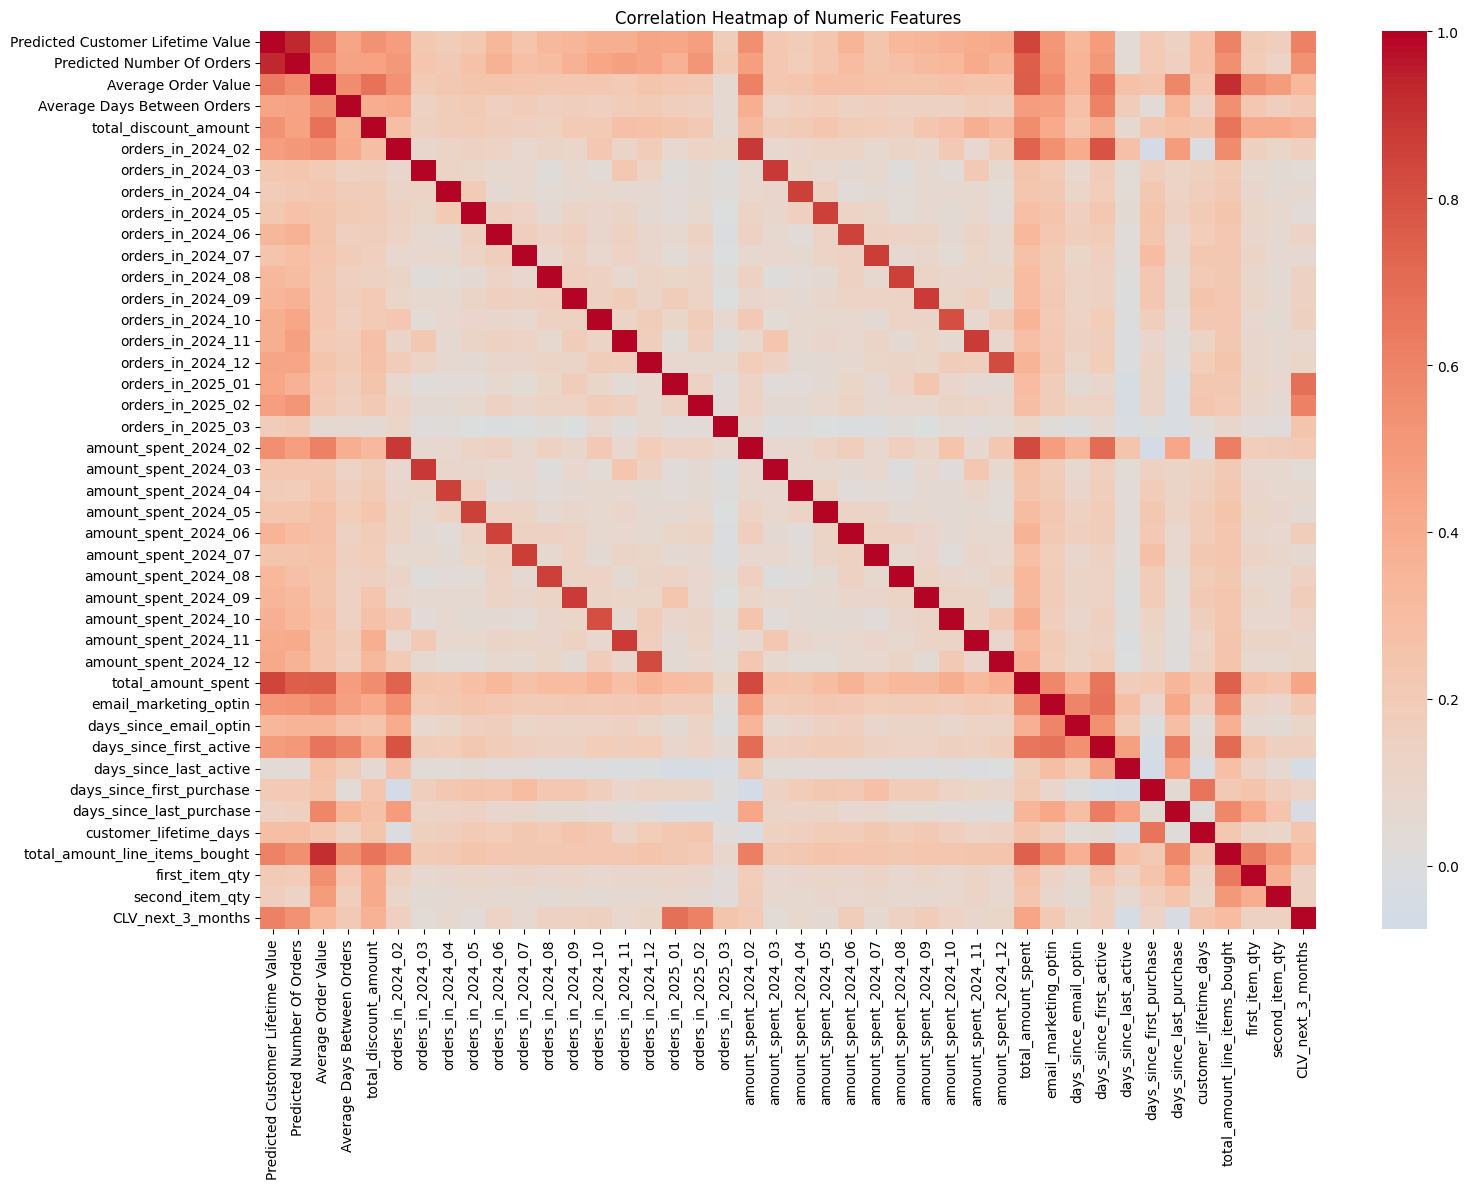

In [9]:
import seaborn as sns

# Load data with target
input_file = os.path.join(PROCESSED_DATA_PATH, "clv_model_data_with_target.csv")
df = pd.read_csv(input_file)
import matplotlib.pyplot as plt

# Only use numeric columns for correlation
corr = df.select_dtypes(include='number').corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


In [11]:
# Load data with target
input_file = os.path.join(PROCESSED_DATA_PATH, "clv_model_data_with_target.csv")
df = pd.read_csv(input_file)
# Drop identifiers
df = df.drop(columns=["Email"])

# Encode boolean columns as integers
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

# Fill NaNs
df.fillna(0, inplace=True)

# Separate features and target
X = df.drop(columns=["CLV_next_3_months"])
y = df["CLV_next_3_months"].squeeze()

# Encode object/categorical columns using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Replace ALL non-alphanumeric characters with underscores
X.columns = X.columns.str.replace(r"[^a-zA-Z0-9_]", "_", regex=True)
X.head()

,Predicted_Customer_Lifetime_Value,Predicted_Number_Of_Orders,Average_Order_Value,Average_Days_Between_Orders,total_discount_amount,orders_in_2024_02,orders_in_2024_03,orders_in_2024_04,orders_in_2024_05,orders_in_2024_06,...,second_item_sku_ym006zxxs,second_item_sku_ys005zm,second_item_sku_ys005zs,second_item_sku_ys005zxs,second_item_sku_ys006gs,second_item_sku_ys006gxs,second_item_sku_ys006gxxs,second_item_sku_ys006zs,second_item_sku_ys006zxs,second_item_sku_yw001
0,0.00,0.00,0.00,0.0,4.74,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
1,8.07,0.11,88.96,0.0,9.89,0.0,1.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,13.27,0.18,128.66,0.0,14.30,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,2.95,0.04,23.76,0.0,3.46,1.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False


## Step 9: Train/Test Split

To evaluate how well our model generalizes to unseen customers, we split our dataset into training and testing sets.

We use an 80/20 split, a common practice in supervised learning.


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
X_train_np = X_train.to_numpy()
y_train_np = np.asarray(y_train).ravel()  # 1D target
X_test_np = X_test.to_numpy()
y_test_np = np.asarray(y_test).ravel()

## Step 10: Baseline for CLV Prediction
Zero Spending: Predict 0 for all customers.

Global Average: Predict average of 3-month spend across all customers.

Customer-Specific Monthly Average × 3: Predict Total Amount Spent / # active months × 3.

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# True values
y_true = y_test_np

# 1. Zero spending baseline
y_zero = np.zeros_like(y_true)

# 2. Global average baseline
global_avg = y_train_np.mean()
y_global = np.full_like(y_true, global_avg)

# 3. Customer-specific monthly avg × 3 (only if available)
# For now, we simulate a per-customer average from training set
# You can replace this logic with actual per-customer monthly avg if available
y_personal_avg = np.full_like(y_true, (y_train_np.mean() / 3) * 3)

# Define a helper function
def print_metrics(name, y_pred):
    print(f"🔹 {name}")
    print("  RMSE:", round(mean_squared_error(y_true, y_pred), 2))
    print("  MAE :", round(mean_absolute_error(y_true, y_pred), 2))
    print("  R²  :", round(r2_score(y_true, y_pred), 4))

# Show results
print_metrics("Zero Spending Baseline", y_zero)
print_metrics("Global Average Baseline", y_global)
print_metrics("Customer Avg x 3 Baseline", y_personal_avg)

## Step 10: Choose, Train, and Evaluate Model

We will use **XGBoost Regressor**, a powerful and efficient model for tabular data.

### Why XGBoost:
- Performs well on structured data
- Handles missing values internally
- Provides feature importance insights
- Scales well for large datasets

We will train the model and evaluate its performance using:
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- R² Score (explained variance)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import time

start = time.time()
# model = XGBRegressor(random_state=42)
model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1,
    random_state=42
)
model.fit(X_train_np, y_train_np)

print(f"Training completed in {time.time() - start:.2f} seconds")

# Predict and evaluate
y_pred = model.predict(X_test_np)
root_mean_squared_error(y_test_np, y_pred)
RMSE_XGBoost = root_mean_squared_error(y_test_np, y_pred)
MAE_XGBoost = mean_absolute_error(y_test_np, y_pred)
R2_XGBoost = r2_score(y_test_np, y_pred)
print("RMSE:", RMSE_XGBoost)
print("MAE:", MAE_XGBoost)
print("R² Score:", R2_XGBoost)

Great the model gets just above 85% accuracy.
## let's plot the results

In [ ]:
import matplotlib.pyplot as plt

# Model performance metrics
rmse = RMSE_XGBoost
mae = MAE_XGBoost
r2 = R2_XGBoost

# Labels and values
metrics = ['RMSE', 'MAE', 'R² Score']
values = [rmse, mae, r2]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='skyblue')
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, max(values) + 5)

# Annotate values on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Predicted vs Actual Scatter Plot
# Shows how well predictions align with true values.
plt.figure(figsize=(6, 6))
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Predicted vs Actual CLV")
plt.grid(True)
plt.tight_layout()
plt.show()

## Let's do the same with Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import time

# Initialize and train model LINEAR REGRESSION
start = time.time()
# lr_model = LinearRegression()
# lr_model.fit(X_train_np, y_train_np)


# Initialize and train model TUNED LINEAR REGRESSION
elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # l1_ratio = 0.5 means equal L1 and L2 penalty
elastic_model.fit(X_train_np, y_train_np)
print(f"Training completed in {time.time() - start:.2f} seconds")

# Predict and evaluate
y_pred_lr = elastic_model.predict(X_test_np)

rmse_lr = root_mean_squared_error(y_test_np, y_pred_lr)
mae_lr = mean_absolute_error(y_test_np, y_pred_lr)
r2_lr = r2_score(y_test_np, y_pred_lr)

print("Linear Regression Results:")
print("RMSE:", rmse_lr)
print("MAE:", mae_lr)
print("R² Score:", r2_lr)

In [ ]:
import matplotlib.pyplot as plt

# Model performance metrics
rmse = rmse_lr
mae = mae_lr
r2 = r2_lr

# Labels and values
metrics = ['RMSE', 'MAE', 'R² Score']
values = [rmse, mae, r2]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color='skyblue')
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, max(values) + 5)

# Annotate values on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Predicted vs Actual Scatter Plot
# Shows how well predictions align with true values.
plt.figure(figsize=(6, 6))
plt.scatter(y_test_np, y_pred_lr, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Predicted vs Actual CLV")
plt.grid(True)
plt.tight_layout()
plt.show()